# FRMOD basics - 1

Import the necessary modules from the frmod package.

In [12]:
from frmod.analysis import VRaster, LandslideMask, FRAnalysis, show_grid

**Read input data and create the VRaster and LandslideMask objects.**  
VRaster objects store the data related to the analyzed layers (eg. elevation, slope). You have to specify four arguments to create a VRaster for the analysis:  
- **name** : The name of the VRaster. Eg. *'elevation'*
- **path** : Path to the raster grid of the layer. All rasters used in the analysis must be in the same grid system (resolution, cellsize, projection). The layer must be compatible with GDAL, but this should not be an issue for most of the common raster formats. Eg. *'./data/layer.sdat'*
- **bins** : The data will be sorted into this many equal-width categories for the analysis. Eg. *10* 
- **categorical** : Set it True if the layer is categorical and set it False if the layer is not categorical. Eg. *True*
  
LandslideMask objects store the data for the mask. The mask is used to separate the landslide and the non-landslide areas. 

In [11]:
elevation = VRaster(name='elevation',
                    path='./data/SRTM31_EG_GF_m.sdat',
                    bins=20,
                    categorical=False)
slope = VRaster(name='slope',
                path='./data/SRTM31_EG_GF_Slope_m.sdat',
                bins=10,
                categorical=False)
geology = VRaster(name='geology_14',
                  path='./data/fdt100_14k.sdat',
                  categorical=True)
scarps = LandslideMask(name='scarps',
                       path='./data/scarps.sdat',
                       ls_marker=1,
                       fold_count=5)

Plot the grid of the elevation VRaster along with its basic statistics.

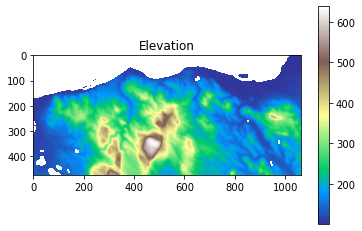

Name: elevation Limits: (100.67122, 638.9841)
Mean: 219.7329864501953 Standard deviation: 95.92752838134766


In [3]:
show_grid(elevation.grid, nodata=elevation.nodata, name='Elevation', cmap='terrain')
elevation.show_info()

Create the FRAnalysis object. Upon instantiation, the frequency ratios are computed for the analyzed layers for each validation fold. 

In [5]:
fra = FRAnalysis(ls_mask=scarps,
                 var_list=[slope,
                           geology,
                           elevation]
                 )

In [ ]:
fra.plot_var_fold_fr('slope', 0)

In [6]:
result_percentile_bins = fra.get_result()

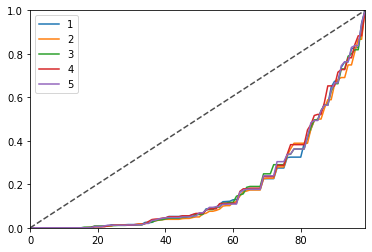

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [7]:
success_rates = fra.get_src()
fra.plot_success_rates()

In [8]:
auc_folds = fra.get_auc()

Auc: 19.253
Auc: 18.821
Auc: 19.383383383383386
Auc: 19.73273273273273
Auc: 19.45745745745746
Mean score: 19.329514714714712; Std: 0.2987633396480596


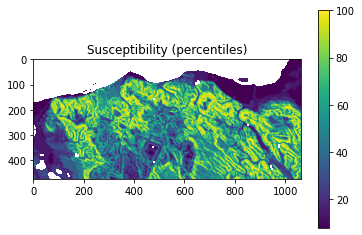

In [9]:
fra.get_percentile_grid(show=True)